In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as pp
import numpy as np

import random
import time
import math

import pickle

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Classes

In [ ]:
class LSTMCell(nn.Module):
  def __init__(self, n_in, n_hid):
    super(LSTMCell, self).__init__()
    self.forget = nn.Linear(n_in+n_hid, n_hid)
    self.input = nn.Linear(n_in+n_hid, n_hid)
    self.gate = nn.Linear(n_in+n_hid, n_hid)
    self.output = nn.Linear(n_in+n_hid, n_hid)

    
  def forward(self, x, tupHC):
    h, c = tupHC
    xs = x.unsqueeze(0)
    new_x = torch.cat((h, xs), dim=1) #customize per data
    f_gate = torch.sigmoid(self.forget(new_x))
    i_gate = torch.sigmoid(self.input(new_x))
    g_gate = torch.tanh(self.gate(new_x))
    o_gate = torch.sigmoid(self.output(new_x))
    new_c = f_gate * c + (i_gate*g_gate) # all elementwise
    new_h = o_gate * torch.tanh(new_c)
    return (new_h, new_c)
  
class LSTMNet(nn.Module):
    def __init__(self, n_in, n_hid, n_out):
      # use LSTM to map sequence of characters to some latent feature representation -> use this latent feature representation to do classification on origin
      super(LSTMNet, self).__init__()
      self.n_hid = n_hid
      self.encode = LSTMCell(n_in, n_hid)
      self.decode = LSTMCell(n_in, n_hid)
      self.fc = nn.Linear(n_hid, n_out)

    def forward(self, xs, hidden=None, ctx=None):
      # xs is tuple of primer and ground, tensor sentences
      primer, ground = xs
      if hidden is None:
        hidden = self.init_hidden()
        ctx = self.init_hidden()
        
      output = torch.Tensor().cuda()
      for i in range(primer.size(0)):
        hidden, ctx = self.encode.forward(primer[i], (hidden, ctx))
      if(ground is None):
        # prediction
        last = wordToTen("<s>").cuda()
        length = 0
        word = ""
        while(word != "</s>" and length < 20):
          hidden, ctx = self.decode.forward(last, (hidden, ctx))
          output = torch.cat((output, hidden), dim=0)
          word = tenToWord(hidden.squeeze(0).cpu())
          last = wordToTen(word).cuda()
          length += 1
      else:
        # training
        for i in range(ground.size(0)):
          hidden, ctx = self.decode.forward(ground[i], (hidden, ctx))
          output = torch.cat((output, hidden), dim=0)
    #     output = self.log_softmax(self.fc(hidden))
  
      return output, (hidden, ctx)
    
    def init_hidden(self):
        '''
        hidden and cell states init to be zeros of shape hidden dim
        '''
        return torch.zeros(1, self.n_hid).cuda()

## Load and Parse Data


In [ ]:
def wordToIdx(wrd):
  return wt_map[wrd]

def wordToTen(wrd):
  return weights_matrix[wordToIdx(wrd)]

def lineToTen(line):
  ten = torch.zeros((len(line), 200)).cuda()
  for i, w in enumerate(line):
    ten[i] = wordToTen(w)
  return ten #.cuda()

def tenToWord(ten):
  maximal = [0,-1]
  for i, w in enumerate(weights_matrix):
    n = (w - ten).norm().item()
    if(n < maximal[0] or maximal[1] == -1):
      maximal = [n, i]
  return list(wt_map.keys())[list(wt_map.values()).index(maximal[1])]

def tenToLine(ten):
  line = []
  cten = ten.cpu()
  for t in cten:
    line.append(tenToWord(t))
  return line

In [ ]:
# glove = pickle.load(open("glove.pkl", "rb"))
wt_map = {}

target_vocab = []
with open("bobsue.voc.txt", "r") as r:
  for line in r:
    target_vocab.append(line.rstrip("\n"))

matrix_len = len(target_vocab)
weights_matrix = torch.zeros((matrix_len, 200))
words_found = 0

for i, word in enumerate(target_vocab):
#   try: 
#     weights_matrix[i] = torch.from_numpy(glove[word])
#     words_found += 1
#   except KeyError:
  weights_matrix[i] = torch.empty(1,200).uniform_(-0.1, 0.1).cuda()
  wt_map[word] = i
torch.save(weights_matrix, "weights_rand.pt")
pickle.dump(wt_map, open("wt_map.pkl", "wb"))

# wt_map = pickle.load(open("wt_map.pkl", "rb"))
# weights_matrix = torch.load("weights_rand.pt")

bobsueTrain = []
with open("bobsue.seq2seq.train.tsv", "r") as f:
  for line in f:
    x1, y1 = line.rstrip("\n").split("\t")
    bobsueTrain.append([lineToTen(x1.split(" ")), lineToTen(y1.split(" "))])
    
print(tenToLine(bobsueTrain[0][1]))

['<s>', 'She', 'ate', 'quickly', 'and', 'asked', 'to', 'be', 'taken', 'home', '.', '</s>']


## Train Loop

In [ ]:
def train(primer_tensor, ground_tensor, model, optimizer, criterion=F.mse_loss):
  optimizer.zero_grad()

  hidden, ctx = None, None
  output, (hidden, ctx) = model((primer_tensor, ground_tensor), hidden, ctx)

  output = output[:-1] # last prediction is meaningless since we fed it </s>
  
  loss = criterion(output, ground_tensor[1:]) # we're not trying to predict <s>
  loss.backward()
  optimizer.step()
  return output, loss.item()
  
  
def evalCorrect(y_pred, ys):
  line = tenToLine(y_pred)
  ground = tenToLine(ys)
  acc = 0
  for q in range(len(y_pred)):
    if(line[q] == ground[q+1]):
      acc += 1 / len(y_pred)
      try:
        correct[line[q]] += 1
      except:
        correct[line[q]] = 1
  return acc, line, ground
    

In [ ]:
#def run(): #added
#########################
#       Training loop   #
#########################
hparams = {
    'learning_rate': 0.1,
    'epochs': 30,
    'hidden_size': 200,
    'logint': 1,
    'set_size' : 500 #6036
}

def randex(all_pairs):
#   pair = random.choice(all_pairs)
  pair = random.choice(all_pairs[0:hparams['set_size']])
#   pair = all_pairs[0]

  p = pair[0]
  q = pair[1]
  return p, q #, lineToTen(p), lineToTen(q)

model = LSTMNet(200, hparams['hidden_size'], 200)
model.to(DEVICE)
opt = torch.optim.Adam(model.parameters(), lr=hparams['learning_rate'])
# opt = torch.optim.SGD(model.parameters(), lr=hparams['learning_rate'])
# opt = torch.optim.SGD(model.parameters(), lr=hparams['learning_rate'], momentum=0.9, weight_decay=1e-3)


epochs = []
losses = []
all_losses = []
some_losses = []
accuracy = []
corrects = []
start = time.time()
batch_accs = []
correct = {}


for e in range(hparams['epochs']):
  acc = 0
  for i in range(hparams['set_size'] + 1):
    pt, gt = randex(bobsueTrain)
    y_pred, loss = train(pt, gt, model, opt)
    losses.append(loss)
    all_losses.append(loss)   
    if(i % 100 == 0):
      acc, line, ground = evalCorrect(y_pred, gt)
      accuracy.append(acc)
      some_losses.append(loss)

    
  if e % hparams['logint'] == 0:
    if(e == hparams['epochs'] // 2):
      hparams['learning_rate'] = 0.01
      for g in opt.param_groups:
        g['lr'] = hparams['learning_rate']
      print("new rate")
    elapsed = (time.time() - start) / 60.
    avg_loss = np.mean(losses)
#       acc = np.mean(corrects)
    acc, line, ground = evalCorrect(y_pred, gt)

    print('Epoch {:7} | Loss: {:5.5f} | Acc: {:.3f} | Elapsed: {:.2f}min'.format(e, avg_loss, acc, elapsed))
    print(line)
    print(ground[1:])
    losses = []
    batch_accs.append(acc)


Epoch       0 | Loss: 0.00354 | Acc: 0.182 | Elapsed: 0.32min
['climbed', 'climbed', 'climbed', 'climbed', 'woman', 'climbed', 'a', 'climbed', '.', '.', '</s>']
['Bob', 'eventually', 'found', 'his', 'keys', 'in', 'his', 'coat', 'pocket', '.', '</s>']
Epoch       1 | Loss: 0.00286 | Acc: 0.200 | Elapsed: 0.65min
['climbed', 'climbed', 'climbed', 'she', 'climbed', 'climbed', '.', 'climbed', '.', '</s>']
['At', 'first', ',', 'Bob', 'was', 'winning', 'the', 'game', '.', '</s>']
Epoch       2 | Loss: 0.00285 | Acc: 0.182 | Elapsed: 0.99min
['climbed', 'onto', 'climbed', 'bit', '.', '.', '.', 'climbed', 'woman', '.', '</s>']
['Sue', 'found', 'the', 'perfect', 'blue', 'dress', 'and', 'black', 'shoes', '.', '</s>']
Epoch       3 | Loss: 0.00286 | Acc: 0.300 | Elapsed: 1.32min
['climbed', 'climbed', 'climbed', 'slow', 'to', 'climbed', '.', 'turned', '.', '</s>']
['She', 'was', 'too', 'shy', 'to', 'ask', 'him', 'out', '.', '</s>']


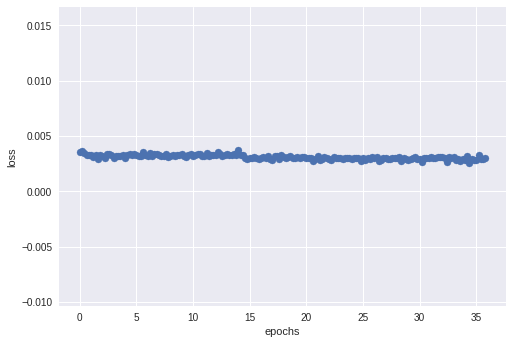

In [ ]:

###

# torch.save(weights_matrix, "weights_rand2.pt")
# print(len(bobsueTrain))
# weights_matrix /= 20
# print(torch.max(weights_matrix))
# model_num += 1
# torch.save(model, "model_{0}.pt".format(model_num))
# order = sorted(correct, key=correct.get, reverse=True)
# for i in range(20):
#   print(order[i], correct[order[i]])

ep = []
for i in range(len(accuracy)):
  ep.append(i/5)


pp.scatter(ep, some_losses)
pp.xlabel("epochs")
pp.ylabel("loss")
pp.show()

###

In [ ]:


bobsueTest = []
with open("bobsue.seq2seq.test.tsv", "r") as f:
  for line in f:
    x1, y1 = line.rstrip("\n").split("\t")
    bobsueTest.append([x1.split(" "), y1.split(" ")])
    
test = random.sample(bobsueTest, 10)
for p, g in test:
  pred, loss = model((lineToTen(p), None), None, None)
  print(tenToLine(pred))

    
with open("bobsue.seq2seq.pred.tsv", "w") as out:
  for p, g in bobsueTest:
    line = " ".join(p)
    pred, loss = model((lineToTen(p), None), None, None)
    line += "\t"
    line += " ".join(tenToLine(pred))
    line += "\n"
    out.write(line)
  

['spend', 'rock', 'free', '.', '</s>']
['spend', 'sauce', 'ever', 'tutor', 'counter', 'to', 'the', 'counter', '.', '</s>']
['counter', 'counter', 'counter', 'to', 'the', 'counter', 'counter', 'sauce', 'counter', '.', '</s>']
['counter', 'counter', 'counter', 'to', 'the', 'counter', 'counter', 'sauce', 'counter', '.', '</s>']
['counter', 'counter', 'counter', 'to', 'the', 'counter', 'counter', 'sauce', 'counter', '.', '</s>']
['spend', 'sauce', 'ever', 'tutor', 'counter', 'to', 'the', 'counter', '.', '</s>']
['counter', 'counter', 'counter', 'to', 'the', 'counter', 'counter', 'sauce', 'counter', '.', '</s>']
['counter', 'counter', 'counter', 'to', 'the', 'counter', 'counter', 'sauce', 'counter', '.', '</s>']
['counter', 'counter', 'counter', 'to', 'the', 'counter', 'counter', 'sauce', 'counter', '.', '</s>']
['counter', 'counter', 'counter', 'to', 'the', 'counter', 'counter', 'sauce', 'counter', '.', '</s>']
